<a href="https://colab.research.google.com/github/adi-103/Automatidata_Project/blob/main/Random_Forest_and_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Random Forest**
- Implement tree-based modeling techniques to predict a binary target class.  
<br/>   

**The purpose** of this model is to find ways to generate more revenue for taxi cab drivers.  
  
**The goal** of this model is to predict whether or not a customer is a generous tipper.  
<br/>  

*This phase has three parts:*

**Part 1:** Ethical considerations
* Consider the ethical implications of the request

* Should the objective of the model be adjusted?

**Part 2:** Feature engineering

* Perform feature selection, extraction, and transformation to prepare the data for modeling

**Part 3:** Modeling

* Build the models, evaluate them, and advise on next steps

**Step 1: Plan**


**Questions to consider:**

1.   What are you being asked to do?
  - I have been asked to build a machine learning model **to predict if a customer will not leave a tip.**


2.   What are the ethical implications of the model? What are the consequences of your model making errors?
  *   What is the likely effect of the model when it predicts a false negative (i.e., when the model says a customer will give a tip, but they actually won't)?
  
  *   What is the likely effect of the model when it predicts a false positive (i.e., when the model says a customer will not give a tip, but they actually will)?  

  - Drivers who didn't receive tips will probably be upset that the app told them a customer would leave a tip. If it happened often, drivers might not trust the app. Drivers are unlikely to pick up people who are predicted to not leave tips. Customers will have difficulty finding a taxi that will pick them up, and might get angry at the taxi company. Even when the model is correct, people who can't afford to tip will find it more difficult to get taxis, which limits the accessibility of taxi service to those who pay extra.

3.   Do the benefits of such a model outweigh the potential problems?
  - It is not good to disincentivize drivers from picking up customers. It could also cause a customer backlash. The problems seem to outweigh benefits.

4.   Would you proceed with the request to build this model? Why or why not?
  - No. Effectively limiting equal access to taxis is ethically problematic, and carries a lot of risk.

5.   Can the objective be modified to make it less problematic?
  - We can build a model that predicts the most generous customers. This could accomplish the goal of helping taxi drivers increase their earnings from tips while preventing the wrongful exclusion of certain people from using taxis.

Suppose you were to modify the modeling objective so, instead of predicting people who won't tip at all, you predicted people who are particularly generous&mdash;those who will tip 20% or more?

**Consider the following questions:**

1.  What features do you need to make this prediction?
  - Ideally, we'd have behavioral history for each customer, so we could know how much they tipped on previous taxi rides. We'd also want times, dates and locations of both pickups and dropoffs, estimated fares, and payment method.

2.  What would be the target variable?  
  - The target variable would be a binary variable i.e. 0 or 1 that indicates whether or not the customer is expected to tip ≥ 20%.

3.  What metric should you use to evaluate your model? Do you have enough information to decide this now?
  - This is a supervised learning, classification task. We could use accuracy, precision, recall, F-score, area under the ROC curve, or a number of other metrics. However, we don't have enough information at this time to know which are most appropriate. We need to know the class balance of the target variable.

**Import Files from Google Drive to Colab**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Imports**

* Import packages
* Load dataset: Pandas is used to read a dataset called 2017_Yellow_Taxi_Trip_Data.csv.

In [42]:
# Import packages

# For numerics + dataframes
import numpy as np
import pandas as pd

# For data visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# For date conversions
import datetime as dt
from datetime import datetime
from datetime import date
from datetime import timedelta

# Scikit-learn functions for pre-processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Packages for OLS
# Scikit-learn functions for data-modeling
# Constructing Random Forest, and XGBoost
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

# Scikit-learn functions for evaluation of metrics
import sklearn.metrics as metrics
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay


In [3]:
# Load dataset into dataframe
df0=pd.read_csv('/content/drive/MyDrive/2017_Yellow_Taxi_Trip_Data.csv')

# Keep 'df0' as the original dataframe and create a copy (df) where changes will go
df = df0.copy()

# Import predicted fares and mean distance and duration from previous course
nyc_preds_means = pd.read_csv('/content/drive/MyDrive/nyc_preds_means.csv')

In [4]:
# Display all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

In [5]:
# Inspect the first few rows of df0
df.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80


In [6]:
# Inspect the first few rows of `nyc_preds_means`
nyc_preds_means.head()

,mean_duration,mean_distance,predicted_fare
0,22.847222,3.521667,16.434245
1,24.470370,3.108889,16.052218
2,7.250000,0.881429,7.053706
3,30.250000,3.700000,18.731650
4,14.616667,4.435000,15.845642


**Join the two data frames**
- Join the two data frames using a method of your choice.

In [7]:
# Merge datasets
df = df.merge(nyc_preds_means, left_index = True, right_index = True)
df.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,22.847222,3.521667,16.434245
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,24.470370,3.108889,16.052218
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.250000,0.881429,7.053706
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,3.700000,18.731650
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80,14.616667,4.435000,15.845642


**Step 2: Analyze**

  **Feature engineering**

- Much of this data had already been prepared and exploratory data analysis (EDA) had already been performed in previous steps.

In [8]:
# Call `info()` on the new combined dataframe.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             22699 non-null  int64  
 1   VendorID               22699 non-null  int64  
 2   tpep_pickup_datetime   22699 non-null  object 
 3   tpep_dropoff_datetime  22699 non-null  object 
 4   passenger_count        22699 non-null  int64  
 5   trip_distance          22699 non-null  float64
 6   RatecodeID             22699 non-null  int64  
 7   store_and_fwd_flag     22699 non-null  object 
 8   PULocationID           22699 non-null  int64  
 9   DOLocationID           22699 non-null  int64  
 10  payment_type           22699 non-null  int64  
 11  fare_amount            22699 non-null  float64
 12  extra                  22699 non-null  float64
 13  mta_tax                22699 non-null  float64
 14  tip_amount             22699 non-null  float64
 15  to

You know from your EDA that customers who pay cash generally have a tip amount of $0. To meet the modeling objective, you'll need to sample the data to select only the customers who pay with credit card.

Copy `df0` and assign the result to a variable called `df1`. Then, use a Boolean mask to filter `df1` so it contains only customers who paid with credit card.

In [9]:
# Subset the data to isolate only customers who paid by credit card
df1 = df[df['payment_type'] == 1]

**Target**

Notice that there isn't a column that indicates tip percent, which is what you need to create the target variable. You'll have to engineer it.

Add a `tip_percent` column to the dataframe by performing the following calculation:  
<br/>  


$$tip\ percent = \frac{tip\ amount}{total\ amount - tip\ amount}$$  

Round the result to three places beyond the decimal. **This is an important step.** It affects how many customers are labeled as generous tippers. In fact, without performing this step, approximately 1,800 people who do tip ≥ 20% would be labeled as not generous.

To understand why, you must consider how floats work. Computers make their calculations using floating-point arithmetic (hence the word "float"). Floating-point arithmetic is a system that allows computers to express both very large numbers and very small numbers with a high degree of precision, encoded in binary. However, precision is limited by the number of bits used to represent a number, which is generally 32 or 64, depending on the capabilities of your operating system.

This comes with limitations in that sometimes calculations that should result in clean, precise values end up being encoded as very long decimals.

In [10]:
# Ensure 'df1' is a copy to avoid SettingWithCopyWarning if it's a view
df1 = df1.copy()

# Calculate 'tip_percent' and handle division by zero explicitly
df1['tip_percent'] = (df1['tip_amount'] / (df1['total_amount'] - df1['tip_amount'])).replace(0, 1)
df1['tip_percent'] = df1['tip_percent'].round(3)

# Display the DataFrame
print(df1)

       Unnamed: 0  VendorID    tpep_pickup_datetime   tpep_dropoff_datetime  \
0        24870114         2   03/25/2017 8:55:43 AM   03/25/2017 9:09:47 AM   
1        35634249         1   04/11/2017 2:53:28 PM   04/11/2017 3:19:58 PM   
2       106203690         1   12/15/2017 7:26:56 AM   12/15/2017 7:34:08 AM   
3        38942136         2   05/07/2017 1:17:59 PM   05/07/2017 1:48:14 PM   
5        23345809         2   03/25/2017 8:34:11 PM   03/25/2017 8:42:11 PM   
...           ...       ...                     ...                     ...   
22692    60425673         1   07/16/2017 3:22:51 AM   07/16/2017 3:40:52 AM   
22693    67858616         2  08/10/2017 10:20:04 PM  08/10/2017 10:29:31 PM   
22695    66632549         2   08/06/2017 4:43:59 PM   08/06/2017 5:24:47 PM   
22697    60217333         2  07/15/2017 12:56:30 PM   07/15/2017 1:08:26 PM   
22698    17208911         1   03/02/2017 1:02:49 PM   03/02/2017 1:16:09 PM   

       passenger_count  trip_distance  RatecodeID s

**Create another column called `generous`**
- This will be the target variable. The column should be a binary indicator of whether or not a customer tipped ≥ 20% (0=no, 1=yes).

1. Begin by making the `generous` column a copy of the `tip_percent` column.
2. Reassign the column by converting it to Boolean (True/False).
3. Reassign the column by converting Boolean to binary (1/0).

In [11]:
# Create 'generous' column (target) using .loc to avoid SettingWithCopyWarning
df1.loc[:, 'generous'] = (df1['tip_percent'] >= 0.2).astype(int)

# Display the DataFrame
print(df1)

       Unnamed: 0  VendorID    tpep_pickup_datetime   tpep_dropoff_datetime  \
0        24870114         2   03/25/2017 8:55:43 AM   03/25/2017 9:09:47 AM   
1        35634249         1   04/11/2017 2:53:28 PM   04/11/2017 3:19:58 PM   
2       106203690         1   12/15/2017 7:26:56 AM   12/15/2017 7:34:08 AM   
3        38942136         2   05/07/2017 1:17:59 PM   05/07/2017 1:48:14 PM   
5        23345809         2   03/25/2017 8:34:11 PM   03/25/2017 8:42:11 PM   
...           ...       ...                     ...                     ...   
22692    60425673         1   07/16/2017 3:22:51 AM   07/16/2017 3:40:52 AM   
22693    67858616         2  08/10/2017 10:20:04 PM  08/10/2017 10:29:31 PM   
22695    66632549         2   08/06/2017 4:43:59 PM   08/06/2017 5:24:47 PM   
22697    60217333         2  07/15/2017 12:56:30 PM   07/15/2017 1:08:26 PM   
22698    17208911         1   03/02/2017 1:02:49 PM   03/02/2017 1:16:09 PM   

       passenger_count  trip_distance  RatecodeID s

**Create a day column**

Convert the `tpep_pickup_datetime` and `tpep_dropoff_datetime` columns to datetime. </br>
To convert to day name, use `dt.day_name()` on the column.

In [12]:
# Convert 'tpep_pickup_datetime' and 'tpep_dropoff_datetime' to datetime
df1['tpep_pickup_datetime'] = pd.to_datetime(df1['tpep_pickup_datetime'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
df1['tpep_dropoff_datetime'] = pd.to_datetime(df1['tpep_dropoff_datetime'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')

# Display the DataFrame to verify
print(df1)

       Unnamed: 0  VendorID tpep_pickup_datetime tpep_dropoff_datetime  \
0        24870114         2  2017-03-25 08:55:43   2017-03-25 09:09:47   
1        35634249         1  2017-04-11 14:53:28   2017-04-11 15:19:58   
2       106203690         1  2017-12-15 07:26:56   2017-12-15 07:34:08   
3        38942136         2  2017-05-07 13:17:59   2017-05-07 13:48:14   
5        23345809         2  2017-03-25 20:34:11   2017-03-25 20:42:11   
...           ...       ...                  ...                   ...   
22692    60425673         1  2017-07-16 03:22:51   2017-07-16 03:40:52   
22693    67858616         2  2017-08-10 22:20:04   2017-08-10 22:29:31   
22695    66632549         2  2017-08-06 16:43:59   2017-08-06 17:24:47   
22697    60217333         2  2017-07-15 12:56:30   2017-07-15 13:08:26   
22698    17208911         1  2017-03-02 13:02:49   2017-03-02 13:16:09   

       passenger_count  trip_distance  RatecodeID store_and_fwd_flag  \
0                    6           3.34  

Create a `day` column that contains only the day of the week when each passenger was picked up. Then, convert the values to lowercase.

In [13]:
 # Create a 'day' col using .loc to avoid SettingWithCopyWarning
df1.loc[:, 'day'] = df1['tpep_pickup_datetime'].dt.day_name().str.lower()

**Create time of day columns**

- Next, engineer four new columns that represent time of day bins. Each column should contain binary values (0=no, 1=yes) that indicate whether a trip began (picked up) during the following times:

`am_rush` = [06:00&ndash;10:00)  
`daytime` = [10:00&ndash;16:00)  
`pm_rush` = [16:00&ndash;20:00)  
`nighttime` = [20:00&ndash;06:00)  

- To do this, first create the four columns. For now, each new column should be identical and contain the same information: the hour (only) from the `tpep_pickup_datetime` column.

In [14]:
# Create 'am_rush' col
df1.loc[:, 'am_rush'] = df1['tpep_pickup_datetime'].dt.hour

# Create 'daytime' col
df1.loc[:, 'daytime'] = df1['tpep_pickup_datetime'].dt.hour

# Create 'pm_rush' col
df1.loc[:, 'pm_rush'] = df1['tpep_pickup_datetime'].dt.hour

# Create 'nighttime' col
df1.loc[:, 'nighttime'] = df1['tpep_pickup_datetime'].dt.hour

There will be four functions to convert each new column to binary (0/1) `am_rush`, `daytime`, `pm_rush`, and `nighttime`.
If the hour is between [06:00–10:00), it returns 1, otherwise, it returns 0.

In [15]:
# Define 'am_rush()' conversion function [06:00–10:00)
def am_rush(hour):
    if 6 <= hour['am_rush'] < 10:
        val = 1
    else:
        val = 0
    return val

Now, apply the `am_rush()` function to the `am_rush` series to perform the conversion. Print the first five values of the column to make sure it did what you expected it to do.

**Note:** If the cell runs twice, the function will be reapplied and the values will all be changed to 0.

In [16]:
# Apply 'am_rush' function to the 'am_rush' series
df1['am_rush'] = df1.apply(am_rush, axis=1)
df1['am_rush'].head()

,am_rush
0,1
1,0
2,1
3,0
5,0


In [17]:
# Define 'pm_rush()' conversion function [16:00–20:00)
def pm_rush(hour):
    if 16 <= hour['pm_rush'] < 20:
        val = 1
    else:
        val = 0
    return val

In [18]:
# Apply 'pm_rush()' function to the 'pm_rush' series
df1.loc[:, 'pm_rush'] = df1.apply(pm_rush, axis=1)

In [19]:
# Define 'nighttime()' conversion function [20:00–06:00)
def nighttime(hour):
    if 20 <= hour['nighttime'] < 24:
        val = 1
    elif 0 <= hour['nighttime'] < 6:
        val = 1
    else:
        val = 0
    return val

In [20]:
# Apply 'nighttime' function to the 'nighttime' series
df1.loc[:, 'nighttime'] = df1.apply(nighttime, axis = 1)

**Create `month` column**
- Now, create a `month` column that contains only the abbreviated name of the month when each passenger was picked up, then convert the result to lowercase.

In [21]:
# Create 'month' col
df1.loc[:, 'month'] = df1['tpep_pickup_datetime'].dt.strftime('%b').str.lower()

In [22]:
# Examine the first five rows of your dataframe.
df1.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare,tip_percent,generous,day,am_rush,daytime,pm_rush,nighttime,month
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,22.847222,3.521667,16.434245,0.200,1,saturday,1,8,0,0,mar
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,24.470370,3.108889,16.052218,0.238,1,tuesday,0,14,0,0,apr
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.250000,0.881429,7.053706,0.199,0,friday,1,7,0,0,dec
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,3.700000,18.731650,0.300,1,sunday,0,13,0,0,may
5,23345809,2,2017-03-25 20:34:11,2017-03-25 20:42:11,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36,11.855376,2.052258,10.441351,0.200,1,saturday,0,20,0,1,mar


**Drop columns**
- Drop redundant and irrelevant columns as well as those that would not be available when the model is deployed. This includes information like payment type, trip distance, tip amount, tip percentage, total amount, toll amount, etc. The target variable (`generous`) must remain in the data because it will get isolated as the `y` data for modeling.

In [23]:
# Drop columns
drop_columns = ['Unnamed: 0', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
                'payment_type', 'store_and_fwd_flag', 'trip_distance',
                'fare_amount', 'extra', 'mta_tax', 'improvement_surcharge',
                'tip_amount', 'tip_percent', 'total_amount', 'tolls_amount']

df1 = df1.drop(drop_columns, axis = 1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15265 entries, 0 to 22698
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   VendorID         15265 non-null  int64  
 1   passenger_count  15265 non-null  int64  
 2   RatecodeID       15265 non-null  int64  
 3   PULocationID     15265 non-null  int64  
 4   DOLocationID     15265 non-null  int64  
 5   mean_duration    15265 non-null  float64
 6   mean_distance    15265 non-null  float64
 7   predicted_fare   15265 non-null  float64
 8   generous         15265 non-null  int64  
 9   day              15265 non-null  object 
 10  am_rush          15265 non-null  int64  
 11  daytime          15265 non-null  int32  
 12  pm_rush          15265 non-null  int64  
 13  nighttime        15265 non-null  int64  
 14  month            15265 non-null  object 
dtypes: float64(3), int32(1), int64(9), object(2)
memory usage: 1.8+ MB


**Variable encoding**
- Many of the columns are categorical and will need to be dummied (converted to binary). Some of these columns are numeric, but they actually encode categorical information, such as `RatecodeID` and the pickup and dropoff locations. To make these columns recognizable to the `get_dummies()` function as categorical variables, you'll first need to convert them to `type(str)`.

1. Define a variable called `cols_to_str`, which is a list of the numeric columns that contain categorical information and must be converted to string: `RatecodeID`, `PULocationID`, `DOLocationID`.
2. Write a for loop that converts each column in `cols_to_str` to string.

In [24]:
# 1. Define list of cols to convert to string
cols_to_str = ['RatecodeID', 'PULocationID', 'DOLocationID', 'VendorID']

# 2. Convert each column to string
for col in cols_to_str:
    df1[col] = df1[col].astype('str')

To convert to string, use `astype(str)` on the column.

**Convert all the categorical columns to binary**

1. Call `get_dummies()` on the dataframe and assign the results back to a new dataframe called `df2`.

In [25]:
# Convert categoricals to binary
df2 = pd.get_dummies(df1, drop_first = True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15265 entries, 0 to 22698
Columns: 347 entries, passenger_count to month_sep
dtypes: bool(338), float64(3), int32(1), int64(5)
memory usage: 6.0 MB


**Evaluation metric**

Before modeling, you must decide on an evaluation metric.

1. Examine the class balance of your target variable.

In [26]:
# Get class balance of 'generous' col
df2['generous'].value_counts(normalize=True)

,proportion
generous,
1,0.566983
0,0.433017


**Note:**
- A little over half of the customers in this dataset were "generous" (tipped ≥ 20%). The dataset is very nearly balanced.

- To determine a metric, consider the cost of both kinds of model error:
  * False positives (the model predicts a tip ≥ 20%, but the customer does not give one)
  * False negatives (the model predicts a tip < 20%, but the customer gives more)

- False positives are worse for cab drivers, because they would pick up a customer expecting a good tip and then not receive one, frustrating the driver.

- False negatives are worse for customers, because a cab driver would likely pick up a different customer who was predicted to tip more&mdash;even when the original customer would have tipped generously.

**The stakes are relatively even. You want to help taxi drivers make more money, but you don't want this to anger customers. Your metric should weigh both precision and recall equally. Which metric is this?**

- The F1 score is the metric that places equal weight on true positives and false positives, and so therefore on precision and recall.

**Construct**

**Modeling**

**Split the data**
- The only remaining step is to split the data into features/target variable and training/testing data.
  1. Define a variable `y` that isolates the target variable (`generous`).
  2. Define a variable `X` that isolates the features.
  3. Split the data into training and testing sets. Put 20% of the samples into the test set, stratify the data, and set the random state.

In [27]:
# Isolate target variable (y)
y = df2['generous']

# Isolate the features (X)
X = df2.drop('generous', axis = 1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)

##### **Random forest**

Begin with using `GridSearchCV` to tune a random forest model.

1. Instantiate the random forest classifier `rf` and set the random state.

2. Create a dictionary `cv_params` of any of the following hyperparameters and their corresponding values to tune. The more you tune, the better your model will fit the data, but the longer it will take.
 - `max_depth`  
 - `max_features`  
 - `max_samples`
 - `min_samples_leaf`  
 - `min_samples_split`
 - `n_estimators`  

3. Define a set `scoring` of scoring metrics for GridSearch to capture (precision, recall, F1 score, and accuracy).

4. Instantiate the `GridSearchCV` object `rf1`. Pass to it as arguments:
 - estimator=`rf`
 - param_grid=`cv_params`
 - scoring=`scoring`
 - cv: define the number of you cross-validation folds you want (`cv=_`)
 - refit: indicate which evaluation metric you want to use to select the model (`refit=_`)


**Note:** `refit` should be set to `'f1'`.<font/>

In [28]:
# 1. Instantiate the random forest classifier
rf = RandomForestClassifier()


# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [None, 10, 20, 30],
             'max_features': [1.0],
             'max_samples': [0.7],
             'min_samples_leaf': [1],
             'min_samples_split': [2],
             'n_estimators': [10, 50, 100]}


# 3. Define a set of scoring metrics to capture
scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall'
}


# 4. Instantiate the GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=cv_params, scoring=scoring, refit='f1', cv=5, verbose=1)


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


# Define multiple scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall'
}

Now fit the model to the training data.

Note that, depending on how many options you include in your search grid and the number of cross-validation folds you select, this could take a very long time&mdash;even hours. If you use 4-fold validation and include only one possible value for each hyperparameter and grow 300 trees to full depth, it should take about 5 minutes. If you add another value for GridSearch to check for, say, `min_samples_split` (so all hyperparameters now have 1 value except for `min_samples_split`, which has 2 possibilities), it would double the time to ~10 minutes. Each additional parameter would approximately double the time.

In [29]:
# Fit the model
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 20, 30], 'max_features': [1.0],
                         'max_samples': [0.7], 'min_samples_leaf': [1],
                         'min_samples_split': [2],
                         'n_estimators': [10, 50, 100]},
             refit='f1',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall'},
             verbose=1)

**Note: **If you get a warning that a metric is 0 due to no predicted samples, think about how many features you're sampling with `max_features`. How many features are in the dataset? How many are likely predictive enough to give good predictions within the number of splits you've allowed (determined by the `max_depth` hyperparameter)? Consider increasing `max_features`.

</details>

If you want, use `pickle` to save your models and read them back in. This can be particularly helpful when performing a search over many possible hyperparameter values.

**Examine the best average score across all the validation folds**

In [30]:
# Examine best score
grid_search.best_score_

0.7806786051541328

**Examine the best combination of hyperparameters**

In [31]:
grid_search.best_params_

{'max_depth': 10,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

**Use the `make_results()` function to output all of the scores of your model.**

Note that it accepts three arguments.

In [32]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
    model_name (string): what you want the model to be called in the output table
    model_object: a fit GridSearchCV object
    metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                 'recall': 'mean_test_recall',
                 'f1': 'mean_test_f1',
                 'accuracy': 'mean_test_accuracy',
                 }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy],
                        },
                       )
    return table

**Call `make_results()` on the GridSearch object.**

In [33]:
results = make_results('Random Forest CV', grid_search, 'f1')
results

,model,precision,recall,F1,accuracy
0,Random Forest CV,0.746503,0.818183,0.780679,0.738034


Results should produce an acceptable model across the board.

Typically scores of 0.65 or better are considered acceptable, but this is always dependent on your use case.

In [34]:
# Get scores on test data
rf_preds = grid_search.best_estimator_.predict(X_test)

**Use the `get_test_scores()` function to generate the scores on the test data and then assign the results to `rf_test_scores`.**

In [35]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
    model_name (string): Your choice: how the model will be named in the output table
    preds: numpy array of test predictions
    y_test_data: numpy array of y_test data

    Out:
    table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy]
                        })

    return table

**Random Forest test results**
- Call `rf_test_scores` to output the results.

In [36]:
 # Get scores on test data
rf_test_scores = get_test_scores('Random Forest Test', rf_preds, y_test)
rf_test_scores

,model,precision,recall,F1,accuracy
0,Random Forest Test,0.731707,0.802064,0.765272,0.725177


In [37]:
results = pd.concat([results, rf_test_scores], axis = 0)
results

,model,precision,recall,F1,accuracy
0,Random Forest CV,0.746503,0.818183,0.780679,0.738034
0,Random Forest Test,0.731707,0.802064,0.765272,0.725177


**Results:**

**Question to consider:** How do your test results compare to your validation results?

- All the evaluation metrics on the CV are slightly higher as compared to the test set.
- Overall the Random Forest Model demonstrates slightly better performance during cross-validation compared to the test set across all metrics.
- This difference in performance could be attributed to the fact that Cross-validation averages results over multiple splits of the data, while the test set provides a single evaluation.
- The slight drop in metrics on the test set indicates that the model might slightly overfit to the training data used in cross-validation.


The Random Forest Model shows good performance with only a slight drop in metrics when evaluated on the test set compared to cross-validation; indicating a well generalized model.

##**XGBoost**

 Try to improve the scores using an XGBoost model.

1. Instantiate the XGBoost classifier `xgb` and set `objective='binary:logistic'`. Also set the random state.

2. Create a dictionary `cv_params` of the following hyperparameters and their corresponding values to tune:
 - `max_depth`
 - `min_child_weight`
 - `learning_rate`
 - `n_estimators`

3. Define a set `scoring` of scoring metrics for grid search to capture (precision, recall, F1 score, and accuracy).

4. Instantiate the `GridSearchCV` object `xgb1`. Pass to it as arguments:
 - estimator=`xgb`
 - param_grid=`cv_params`
 - scoring=`scoring`
 - cv: define the number of cross-validation folds you want (`cv=_`)
 - refit: indicate which evaluation metric you want to use to select the model (`refit='f1'`)

In [46]:
# 1. Instantiate the XGBoost classifier
xgb = XGBClassifier(objective = 'binary:logistic')

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [8],
             'min_child_weight': [2],
             'learning_rate': [0.1],
             'n_estimators': [500]}

# 3. Define a set of scoring metrics to capture
scoring = {'accuracy': 'accuracy',
           'precision': 'precision',
           'recall': 'recall',
           'f1': 'f1'}

# 4. Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring = scoring, cv = 4, refit = 'f1')

**Fit the model to the `X_train` and `y_train` data.**

In [47]:
%%time
xgb_cv.fit(X_train, y_train)

CPU times: user 47.7 s, sys: 229 ms, total: 48 s
Wall time: 30.7 s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.1], 'max_depth': [8],
                         'min_child_weight': [2], 'n_estimators': [500]},
             refit='f1',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall'})

**Get the best score from this model**

In [48]:
# Examine best score
xgb_cv.best_score_

0.7467271554391921

**And the best parameters**

In [49]:
# Examine best parameters
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 8,
 'min_child_weight': 2,
 'n_estimators': 500}

**XGB CV Results**

- Use the `make_results()` function to output all of the scores of your model. Note that it accepts three arguments.

In [50]:
# Call 'make_results()' on the GridSearch object
xgb1_cv_results = make_results('XGBoost CV', xgb_cv, 'f1')

In [51]:
results = pd.concat([results, xgb1_cv_results], axis = 0)
results

,model,precision,recall,F1,accuracy
0,Random Forest CV,0.746503,0.818183,0.780679,0.738034
0,Random Forest Test,0.731707,0.802064,0.765272,0.725177
0,XGBoost CV,0.718798,0.776942,0.746727,0.699686


Use this model to predict on the test data. Assign the results to a variable called `xgb_preds`.

You cannot call `predict()` on the GridSearchCV object directly. You must call it on the `best_estimator_`.

In [52]:
# Get scores on test data
xgb_preds = xgb_cv.best_estimator_.predict(X_test)

**XGB test results**

1. Use the `get_test_scores()` function to generate the scores on the test data. Assign the results to `xgb_test_scores`.
2. Call `xgb_test_scores` to output the results.

In [53]:
# Get scores on test data
xgb_test_scores = get_test_scores('XG Boost Test', xgb_preds, y_test)
results = pd.concat([results, xgb_test_scores], axis = 0)
results

,model,precision,recall,F1,accuracy
0,Random Forest CV,0.746503,0.818183,0.780679,0.738034
0,Random Forest Test,0.731707,0.802064,0.765272,0.725177
0,XGBoost CV,0.718798,0.776942,0.746727,0.699686
0,XG Boost Test,0.705185,0.752814,0.728221,0.686141


**Question:** Compare these scores to the random forest test scores. What do you notice? Which model would you choose?

- The F1 score is lower than the random forest model.
- Random Forest outperforms XGBoost across all metrics (precision, recall, F1 score, accuracy) on both the cross-validation and test sets. This suggests that Random Forest is a better model.
- The slight drop in performance from CV to test in both models indicates a small degree of overfitting, but Random Forest shows more robustness compared to XGBoost.
- Given that both models exhibit performance drops from CV to test, Random Forest's relatively higher metrics imply better generalization to unseen data.
- Both models are acceptable, but the Random Forest Model is the champion model.

**Recommendation:**

- Based on the metrics provided, Random Forest should be preferred over XGBoost as it provides better precision, recall, F1 score, and accuracy, which are critical for reliable model performance.

**Plot a confusion matrix of the model's predictions on the test data**

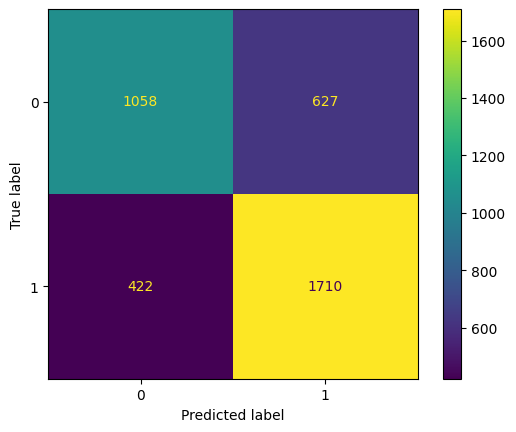

In [55]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, rf_preds, labels = grid_search.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = grid_search.classes_)
disp.plot(values_format = '')

**Question:** What type of errors are more common for your model?

- The model is almost twice as likely to predict a false positive than it is to predict a false negative.
- Therefore, type I errors are more common. This is less desirable, because it's better for a driver to be pleasantly surprised by a generous tip when they weren't expecting one than to be disappointed by a low tip when they were expecting a generous one. However, the overall performance of this model is satisfactory.

**Feature importance**

- Use the `feature_importances_` attribute of the best estimator object to inspect the features of your final model. You can then sort them and plot the most important ones.

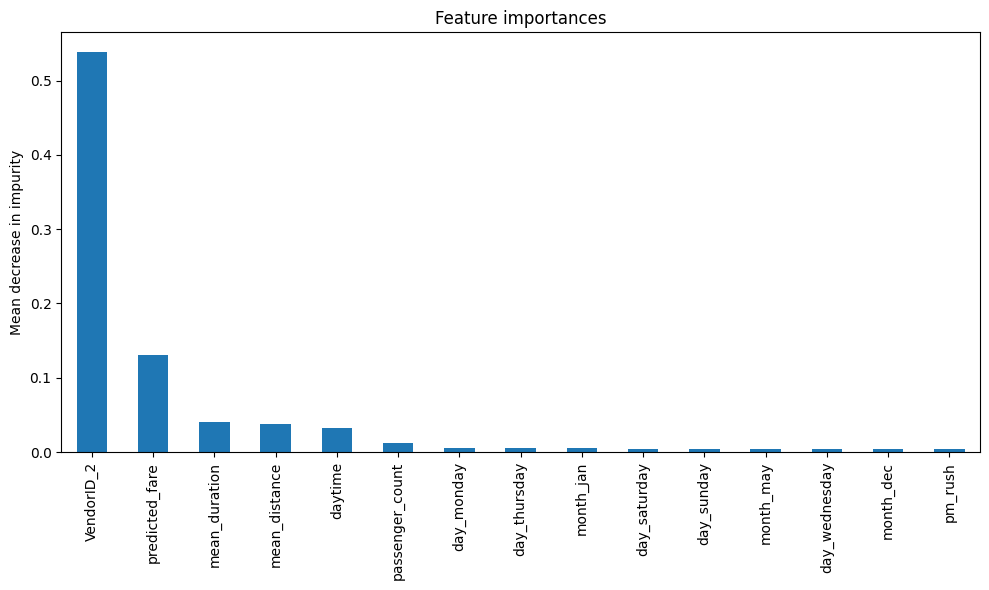

In [58]:
importances = grid_search.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test.columns)
rf_importances = rf_importances.sort_values(ascending = False)[:15]

fig, ax = plt.subplots(figsize =  (10,6))
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()

##**Execute**

Consider the questions in your PACE Strategy Document to reflect on the Execute stage.

###**Conclusion**

In this step, use the results of the models above to formulate a conclusion. Consider the following questions:

1. **Would you recommend using this model? Why or why not?**  
Yes, this is model performs acceptably. Its F<sub>1</sub> score was 0.7235 and it had an overall accuracy of 0.6865. It correctly identified ~78% of the actual responders in the test set, which is 48% better than a random guess. It may be worthwhile to test the model with a select group of taxi drivers to get feedback.  


2. **What was your highest scoring model doing? Can you explain how it was making predictions?**   
Unfortunately, random forest is not the most transparent machine learning algorithm. We know that `VendorID`, `predicted_fare`, `mean_duration`, and `mean_distance` are the most important features, but we don't know how they influence tipping. This would require further exploration. It is interesting that `VendorID` is the most predictive feature. This seems to indicate that one of the two vendors tends to attract more generous customers. It may be worth performing statistical tests on the different vendors to examine this further.  


3. **Are there new features that you can engineer that might improve model performance?**  
There are almost always additional features that can be engineered, but hopefully the most obvious ones were generated during the first round of modeling. In our case, we could try creating three new columns that indicate if the trip distance is short, medium, or far. We could also engineer a column that gives a ratio that represents (the amount of money from the fare amount to the nearest higher multiple of \\$5) / fare amount. For example, if the fare were \\$12, the value in this column would be 0.25, because \\$12 to the nearest higher multiple of \\$5 (\\$15) is \\$3, and \\$3 divided by \\$12 is 0.25. The intuition for this feature is that people might be likely to simply round up their tip, so journeys with fares with values just under a multiple of \\$5 may have lower tip percentages than those with fare values just over a multiple of \\$5. We could also do the same thing for fares to the nearest \\$10.

4. **What features would you want to have that would likely improve the performance of your model?**   
It would probably be very helpful to have past tipping behavior for each customer. It would also be valuable to have accurate tip values for customers who pay with cash.
It would be helpful to have a lot more data. With enough data, we could create a unique feature for each pickup/dropoff combination.